In [81]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import feature

In [86]:
# Get source region and target region and init confidence
def load_image(image1, image2):
    image = cv2.imread(image1)
    RGBimage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(image2)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    confidence = (mask == 0).astype('float')
    return image, RGBimage, mask, confidence

# Use edge detection to get front fill Delta Omega from mask image
def get_front_fill(mask):
  ff = (feature.canny(mask)).astype(float)
  itemindex = np.where(ff==1)
  return itemindex

# Use point axis and window_size to get the range of patch psi P(2X2 array)
def patch(image,point, window_size):
  iy,ix = image.shape
  x, y = point
  size = window_size[0]//2
  x_1 = max(x - size, 0)
  y_1 = max(y - size, 0)
  x_2 = min(x + size, ix - 1)
  y_2 = min(y + size, iy - 1)
  patch_size = (y_2-y_1+1, x_2-x_1+1)
  return [(x_1, y_1),(x_2, y_2)], patch_size

# compute point p confidence
def compute_confidence(confidence, point, mask, window_size):
  psiP,_ = patch(mask, point, window_size)
  x_1, y_1 = psiP[0]
  x_2, y_2 = psiP[1]
  area = (x_2-x_1+1) * (y_2-y_1+1)
  t_sum = 0
  for i in range(x_1, x_2 + 1):
      for j in range(y_1, y_2 + 1):
          if mask[j, i] == 0:
              t_sum += confidence[j, i]
  confidence[point[1],point[0]] = t_sum / area
  return confidence,t_sum / area

# Get the gradient of isophote around the patch
def compute_gradient(image,mask):
  alpha = 255
  gx = (cv2.Scharr(image, cv2.CV_64F, 1, 0))/alpha
  gy = (cv2.Scharr(image, cv2.CV_64F, 0, 1))/alpha
  gx[mask==1]=0
  gy[mask==1]=0
  return gx,gy

# Get the unit vector of the normal on front fill
def compute_normal(front_fill,mask):
  gx = cv2.Scharr(mask, cv2.CV_64F, 1, 0)
  gy = cv2.Scharr(mask, cv2.CV_64F, 0, 1)
  normal = []
  for i in range(len(front_fill[0])):
    x,y = front_fill[1][i], front_fill[0][i]
    norm = np.sqrt(gx[y,x]**2 + gy[y,x]**2)
    if norm != 0:
      normal.append([gy[y,x]/norm,-gx[y,x]/norm])
    else:
      normal.append([gy[y,x],-gx[y,x]])
  return normal

# Compute data term by equation
def compute_data(nalba_Ip, normal, point, point_num):
  x,y = point
  alpha = 255
  data = (np.sqrt((nalba_Ip[0][y,x] * normal[point_num][0])**2 + (nalba_Ip[1][y,x] * normal[point_num][1])**2)) / alpha
  return data

# Compute priority for point P
def compute_priority(confidence, data):
  priority = confidence * data
  return priority

# Get the data in patch Psi
def get_patch_data(psi, image):
  startX = psi[0][0]
  endX = psi[1][0]
  startY = psi[0][1]
  endY = psi[1][1]
  return image[startY:endY+1, startX:endX+1]


# Compute the sum of squared differences (SSD) of the already filled pixels in
# the two patches psiP and psiQ
def SSD(psiP, psiQ, rgbimage, source_mask):
  channels = rgbimage.shape[2]
  psiP_data = get_patch_data(psiP, rgbimage)
  psiQ_data = get_patch_data(psiQ, rgbimage)
  ssd = 0
  for i in range(channels):
    difference = psiP_data[:,:,i] - psiQ_data[:,:,i]
    ssd += np.sum(np.square(difference[source_mask]))
  return ssd

# Get the patch data of psi Q
def get_patch_q(q, mask, patch_size):
  ysize = patch_size[0]//2
  xsize = patch_size[1]//2
  startX = q[0] - xsize
  endX = q[0] + xsize
  startY = q[1] - ysize
  endY = q[1] + ysize
  mask_xy = [np.repeat(np.arange(startY, endY+1),patch_size[0]), np.tile(np.arange(startX, endX+1), patch_size[1])]
  if mask[mask_xy].sum() == patch_size[0]*patch_size[1]*255:
    return np.array([[startX, startY],[endX, endY]])
  else: 
    return None

# Find the best match patch psi q hat
def best_match_patch(rgbimage, mask, psiP, patch_size):
  h,w,_ = rgbimage.shape
  ysize = patch_size[0]//2
  xsize = patch_size[1]//2
  ssd = []
  psiQ_hat = []
  psiP_mask_data = get_patch_data(psiP, mask)
  source_index = np.argwhere(psiP_mask_data != 0)
  source_mask = [source_index[:, 0],source_index[:,1]]
  for i in range(xsize, w-xsize-1):
    for j in range(ysize, h-ysize-1):
      psiQ = get_patch_q((i, j), mask, patch_size)
      if type(psiQ) == np.ndarray:
        ssd.append(SSD(psiP, psiQ, rgbimage, source_mask))
        psiQ_hat.append(psiQ)
  index = np.argmin(ssd)
  return psiQ_hat[index]

# Fill the empty pixels in sai P with the value of corresponding pixels in sai q hat.
def fill_image(RGBimage, mask, psiP, psiQ_hat):
  psiP_mask_data = get_patch_data(psiP, mask)
  target_index = np.argwhere(psiP_mask_data != 255)
  target_mask = [target_index[:, 0],target_index[:,1]]
  channels = RGBimage.shape[2]
  psiP_data = get_patch_data(psiP, RGBimage)
  psiQ_hat_data = get_patch_data(psiQ_hat, RGBimage)
  for i in range(channels):
    psiP_data[:,:,i][target_mask] = psiQ_hat_data[:,:,i][target_mask]
  psiP_mask_data[target_mask] = 255

  return RGBimage, mask

# Update confidence in intersection aera of sai P_hat and omega with C(P_hat)
def update_confidence(confidence, saiP_hat, P_hat):
  px,py = P_hat
  curr = confidence[py,px]
  x_1, y_1 = saiP_hat[0]
  x_2, y_2 = saiP_hat[1]
  for i in range(x_1, x_2 + 1):
      for j in range(y_1, y_2 + 1):
        if confidence[j,i] ==0:
          confidence[j,i] = curr
  return confidence

# Inpainting function
# type image1: string
# param image1: the name of the orignal image. s.t 'xxx.png'
# type image2: string
# param image2 the name of the mask image. s.t 'xxx_mask.png'
# type window_size: tuple
# param window_size: a tuple contains the height and width of the patch window(usually h = w). s.t (x,x)
# return: Nothing. The inpainted image will be saved as 'xxx_result.png' under the same directory of this function file

def inpainting(image1, image2, window_size):
  image, RGBimage, mask, confidence = load_image(image1,image2)
  window_size = window_size
  while(not np.all(mask == 255)):
    front_fill = get_front_fill(mask)
    nalba_Ip = compute_gradient(image,mask)
    normal = compute_normal(front_fill,mask)
    ff_priority = []
    for i in range(len(front_fill[0])):
      curr = (front_fill[1][i],front_fill[0][i])
      confidence, curr_confidence = compute_confidence(confidence,curr,mask,window_size)
      curr_data = compute_data(nalba_Ip,normal,curr,i)
      ff_priority.append(compute_priority(curr_confidence,curr_data))
    curr_max = np.argmax(ff_priority)
    curr_idx = (front_fill[1][curr_max],front_fill[0][curr_max])
    psiP, patch_size = patch(image, curr_idx, window_size)
    psiQ_hat = best_match_patch(RGBimage, mask, psiP, patch_size)
    RGBimage, mask = fill_image(RGBimage, mask, psiP, psiQ_hat)
    update_confidence(confidence, psiP, curr_idx)
    print(ff_priority)
    plt.imshow(RGBimage)
  fig = plt.figure()
  plt.imshow(RGBimage)
  index = image1.find(".")
  image3 = image1[:index]+"_result" + image1[index:]
  plt.savefig(image3, dpi=fig.dpi)

In [ ]:
# image, RGBimage, mask, confidence = load_image('mur.png','masque_mur.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

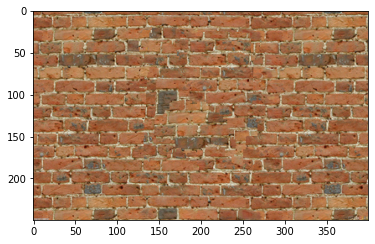

In [ ]:
# window_size = (11,11)
# while(not np.all(mask == 255)):
#   front_fill = get_front_fill(mask)
#   nalba_Ip = compute_gradient(image,mask)
#   normal = compute_normal(front_fill,mask)
#   ff_priority = []
#   for i in range(len(front_fill[0])):
#     curr = (front_fill[1][i],front_fill[0][i])
#     confidence, curr_confidence = compute_confidence(confidence,curr,mask,window_size)
#     curr_data = compute_data(nalba_Ip,normal,curr,i)
#     ff_priority.append(compute_priority(curr_confidence,curr_data))
#   curr_max = np.argmax(ff_priority)
#   curr_idx = (front_fill[1][curr_max],front_fill[0][curr_max])
#   psiP = patch(image, curr_idx, window_size)
#   psiQ_hat = best_match_patch(RGBimage, mask, psiP, window_size)
#   RGBimage, mask = fill_image(RGBimage, mask, psiP, psiQ_hat)
#   update_confidence(confidence, psiP, curr_idx)
# plt.imshow(RGBimage)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a diffe

[0.0002306204878518143, 0.0002050036510322112, 0.00040757803641394984, 0.00017470956999438274, 0.0007110798527653977, 0.00033356809656057796, 6.427542370196086e-05, 0.00022943988239831965, 0.0006541160407331371, 0.0002021995916932924, 0.00010949091885754682, 0.0002452453004218635, 0.00012937262101677963, 0.0009774018539877825, 0.0005467980919603415, 0.00022656228177178337, 0.0, 0.0003588363449955146, 0.0002453208616080446, 0.0003600783816546211, 0.00045580903662942757, 0.0007215903698987382, 0.0003032388919490909, 0.0005201644332843709, 0.0003513637903113057, 0.0006309078499335945, 0.00017108162895308851, 0.00028981680218489336, 0.00011771387368604125, 7.265838710352866e-05, 9.0580113230628e-05, 4.487662819346701e-05, 8.16950947370779e-05, 0.00017131944097599527, 5.0713054490118845e-05, 0.00018826147847416774, 0.0003075098222909464, 0.0002604571627290425, 0.00016611762953927438, 0.001585673714504117, 0.004232128527484012, 0.0002130521352050312, 0.0006040725844123686, 1.620305928016657e

KeyboardInterrupt: ignored

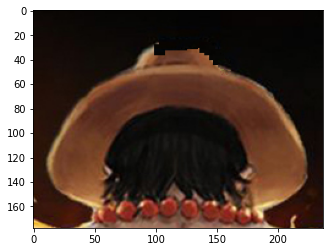

In [88]:
# image1 = "ace.jpeg"
# image2 = "ace_mask.jpeg"
# inpainting(image1, image2, (9,9))

In [78]:
image1 = "ace.jpeg"
image2 = "golf-mask.pgm"
image, RGBimage, mask, confidence = load_image(image1,image2)

In [79]:
import sys
target_index = np.argwhere(mask != 0)
target_mask = [target_index[:, 0],target_index[:,1]]

m = mask[target_mask]

target1_index = np.argwhere(m != 255)
np.set_printoptions(threshold=sys.maxsize)
m[target1_index]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


array([], shape=(0, 1), dtype=uint8)